In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from pprint import pprint
pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

### Data Processing

In [3]:
clinical = pd.read_pickle("C:\\SMU_v2\\clinical_output.pkl").reset_index().drop(columns="index")
to_drop = clinical[clinical['dx_date']=="NA"].index
clinical = drop_by_index(clinical,to_drop)

clinical.drop(columns=['Count_as_DFS','Count_as_OS','Count_as_CSS'],inplace = True)

# drop all rows where dates are null
clinical.dropna(axis=0, \
                subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date',\
                        'Age_@_Dx','size_precise', 'nodespos',\
                        'cerbB2','ProgStage_AJCC8'],\
                inplace=True)

# convert all datetime in dataframe into dateime format for processing
clinical["Date_for_DFS"] = pd.to_datetime(clinical["Date_for_DFS"])
clinical["Date_for_OS"] = pd.to_datetime(clinical["Date_for_OS"])
clinical["Date_for_CSS"] = pd.to_datetime(clinical["Date_for_CSS"])
clinical["dx_date"] = pd.to_datetime(clinical["dx_date"])

# calculate in days
clinical["DFS_days"] = (clinical["Date_for_DFS"] - clinical['dx_date'] )/np.timedelta64(1, 'D')
clinical["OS_days"] = (clinical["Date_for_OS"] - clinical['dx_date'] )/np.timedelta64(1, 'D')
clinical["CSS_days"] = (clinical["Date_for_CSS"] - clinical['dx_date'] )/np.timedelta64(1, 'D')

# alive or dead
clinical['status'] = np.where(clinical['death_age'].isnull(), False, True)

In [4]:
clinical.head(5)

,NRIC,dob,Gender,dx_date,c_tstage,cNstage,cMstage,c_Staging,tstage,nstage,Mstage,p_Staging,diff,TNM_Stage,ProgStage_AJCC8,ER,PR,cerbB2,Her2,size_precise,nodespos,cause_of_death,Date_for_DFS,Date_for_OS,Date_for_CSS,Age_@_Dx,death_age,DFS_days,OS_days,CSS_days,status
0,1df81c7ea14f35b98890,1928-01-01,female,2007-06-12,tx,nx,mx,unknown,tis,n0,m0,dcis/lcis non-invasive,grade 2,dcis/lcis non-invasive,stage 0,positive,positive,negative,negative,4.0,0.0,n,2018-05-05,2018-05-05,2018-05-05,79,90.0,3980.0,3980.0,3980.0,True
1,ba21d66d420a23af9ca6,1963-07-01,female,2018-10-04,tx,nx,mx,unknown,tis,n0,m0,dcis/lcis non-invasive,grade 3,dcis/lcis non-invasive,stage 0,negative,negative,negative,negative,3.0,0.0,NaN,2019-06-26,2019-06-26,2019-06-26,55,NaN,265.0,265.0,265.0,False
2,8cabb7bbdba5d28046dd,1967-04-01,female,2013-12-18,tx,nx,mx,unknown,t1b,n0,m0,stage 1a,grade 1,stage 1a,stage ia,positive,positive,negative,negative,0.2,0.0,NaN,2019-05-02,2019-05-02,2019-05-02,46,NaN,1961.0,1961.0,1961.0,False
4,9dfcd5f81e3692d394e8,1970-09-01,female,2007-05-09,tx,nx,mx,unknown,t2,n2,m0,stage 3a,grade 3,stage 3a,stage iiic,negative,negative,negative,negative,3.5,5.0,NaN,2007-11-20,2007-11-20,2007-11-20,36,NaN,195.0,195.0,195.0,False
5,f20fe5e380e4398c1cdd,1957-05-01,female,2008-05-30,tx,nx,m0,unknown,t1c,n1mic,m0,stage 1b,grade 3,stage 1b,stage iia,negative,negative,negative,negative,1.8,1.0,NaN,2008-07-07,2008-07-07,2008-07-07,51,NaN,38.0,38.0,38.0,False


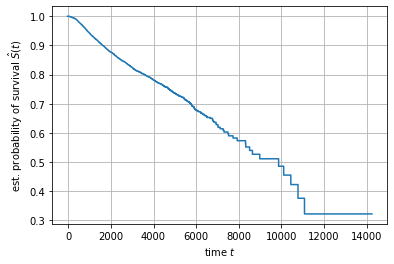

In [5]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(clinical['status'], clinical["OS_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.grid(True)

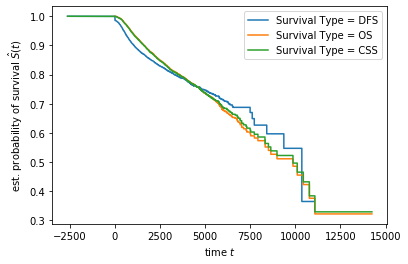

In [6]:
for survival in ("DFS", "OS", 'CSS'):
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        clinical["status"],
        clinical["{}_days".format(survival)])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Survival Type = {}".format(survival))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
# plt.grid(True)
plt.legend(loc="best")

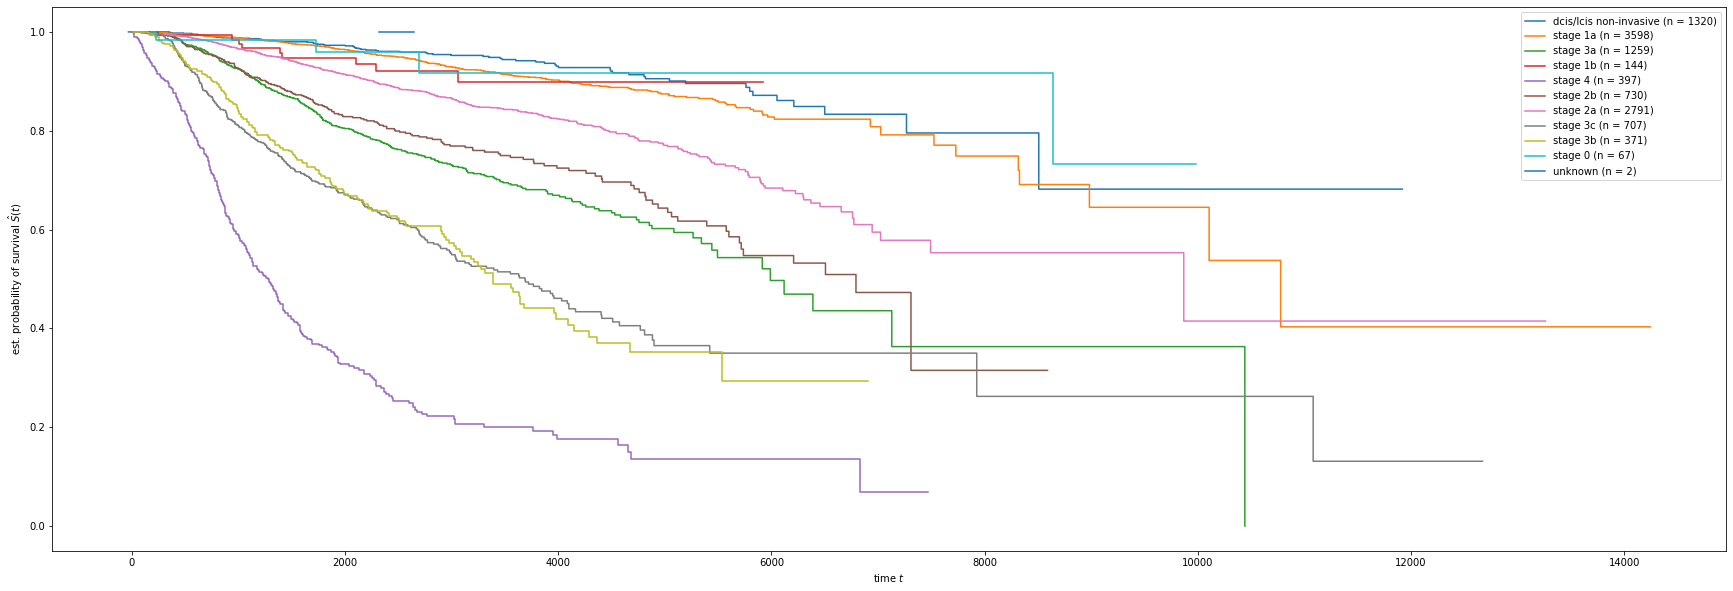

In [7]:
plt.rcParams["figure.figsize"] = (30,10)
for value in clinical["TNM_Stage"].unique():
    mask = clinical["TNM_Stage"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(clinical["status"][mask],
                                                           clinical["OS_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
# plt.grid(True)
plt.legend(loc="best")

### Selecting population pool

Survival times are subject to right-censoring, therefore, we need to consider an individual's status
in addition to survival time. To be fully compatible with scikit-learn, Status and Survival_in_days
need to be stored as a structured array with the first field indicating whether the actual survival time
was observed or if was censored, and the second field denoting the observerd survival time,
which corresponds to the time of death (if Status == 'dead', $\delta = 1$) or the last time that
person was contacted (if Status == 'alive', $\delta = 0$).


In [9]:
# remove columns that is meant for Y
X = clinical[['Gender', 'c_tstage', 'cNstage', 'cMstage', 'c_Staging', 'tstage',\
                      'nstage', 'Mstage', 'p_Staging', 'diff', 'TNM_Stage', 'ProgStage_AJCC8',\
                      'ER', 'PR', 'cerbB2', 'Her2', 'size_precise', 'nodespos', 'Age_@_Dx']]

Y = clinical[['status','OS_days']]


# convert to int since some fields fro age_@_dx is null
X.loc[:,"Age_@_Dx"] = X["Age_@_Dx"].astype("int16")

# OHE for probability
from sksurv.preprocessing import OneHotEncoder
X = OneHotEncoder().fit_transform(X)

# convert Y to structured array
s = Y.dtypes
Y = np.array([tuple(x) for x in Y.values], dtype=list(zip(s.index, s)))

print("X shape: {}".format(X.shape))
print("Y shape: {}".format(Y.shape))

# OHE = [i for i in X.columns if not (i in  ['Age_@_Dx', 'size_precise', 'nodespos'])]
# X = pd.get_dummies(X,columns=OHE,dummy_na=True)

X shape: (11386, 124)
Y shape: (11386,)


### Calculation matrix for CoxPHSurvivalAnalysis - Cox's proportional hazard's model

tol is like the p value
|1 - (new neg. log-likelihood / old neg. log-likelihood) | < tol

In [11]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=0.33, random_state=42)

from sksurv.linear_model import CoxPHSurvivalAnalysis

# since features are highly corelated, reducing alpha values to smaller values allows the learning
estimator = CoxPHSurvivalAnalysis(alpha = 1e-4, verbose = 1)
estimator.fit(X_train, Y_train)

# X.isnull().sum()
# X_train.head()

iter     13: optimization converged


CoxPHSurvivalAnalysis(alpha=0.0001, n_iter=100, ties='breslow', tol=1e-09,
                      verbose=1)

### Log Hazarad Ratio
In survival analysis, the hazard ratio (HR) is the ratio of the hazard rates corresponding to the conditions described by two levels of an explanatory variable. For example, in a drug study, the treated population may die at twice the rate per unit time as the control population. The hazard ratio would be 2, indicating higher hazard of death from the treatment. Or in another study, men receiving the same treatment may suffer a certain complication ten times more frequently per unit time than women, giving a hazard ratio of 10. - wiki

In [12]:
tmp = pd.Series(estimator.coef_, index=X.columns)
tmp = tmp.to_frame("Log Hazarad Ratio")
tmp = tmp.sort_values(by=['Log Hazarad Ratio'])
tmp

,Log Hazarad Ratio
nstage=n0 (i+),-7.833452
c_tstage=t1mic,-5.058297
nstage=n2b,-4.710020
c_Staging=stage 0,-4.397641
TNM_Stage=unknown,-3.771616
p_Staging=stage 1b,-3.342247
c_tstage=t1a,-0.818640
nstage=n1a,-0.692817
ER=unknown,-0.654785
c_tstage=t1c,-0.435940


### Measuring the Performance of Survival Models
Our test data is usually subject to censoring (only verified records are available, events happening in between is skipped), therefore metrics like root mean squared error or correlation are unsuitable. Instead, we use generalization of the area under the receiver operating characteristic (ROC) curve called Harrell's concordance index or c-index.

The interpretation is identical to the traditional area under the ROC curve metric for binary classification:

- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

In [13]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_test)
result = concordance_index_censored(Y_test["status"], Y_test["OS_days"], prediction)
result[0]

0.7821946964362245

### Feature Selection

In [14]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha = 1e-4)
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_test.values, Y_test)
pd.Series(scores, index=X_test.columns).sort_values(ascending=False)

size_precise                  0.684769
nodespos                      0.641712
ProgStage_AJCC8=stage ia      0.621672
c_Staging=unknown             0.620185
cMstage=mx                    0.620004
p_Staging=stage 1a            0.610654
TNM_Stage=stage 1a            0.608805
Age_@_Dx                      0.605522
diff=grade 3                  0.598981
PR=negative                   0.592381
ER=negative                   0.585849
ProgStage_AJCC8=stage iiic    0.585740
PR=positive                   0.585277
c_Staging=stage 4             0.580234
ER=positive                   0.577453
cNstage=nx                    0.577032
ProgStage_AJCC8=stage iv      0.576881
Mstage=m1                     0.576881
p_Staging=stage 4             0.576881
TNM_Stage=stage 4             0.576881
cMstage=m1                    0.575013
tstage=t1c                    0.567304
c_tstage=tx                   0.562789
TNM_Stage=stage 3c            0.561394
nstage=n3                     0.558993
p_Staging=stage 3c       

### Determine features that are useful

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis(alpha = 1e-6, tol= 1e-6))])

from sklearn.model_selection import GridSearchCV

param_grid = {'select__k': np.arange(1, X.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(X, Y)

pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

In [ ]:
pipe.set_params(**gcv.best_params_)
pipe.fit(X, Y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

### RandomSurvivalForest

In [15]:
from sksurv.ensemble import RandomSurvivalForest

random_state = 20
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, Y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [16]:
rsf.score(X_test, Y_test)

0.7947714710547458

### Predicting

For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score can be computed that represents the expected number of events for one particular terminal node. The ensemble prediction is simply the average across all trees in the forest.

In [ ]:
# a = np.empty(X_test.shape[0], dtype=[("age", float), ("pnodes", float)])
# a["age"] = X_test[:, 0]
# a["pnodes"] = X_test[:, 4]

# sort_idx = np.argsort(a, order=["pnodes", "age"])
# X_test_sel = pd.DataFrame(
#     X_test[np.concatenate((sort_idx[:3], sort_idx[-3:]))],
#     columns=feature_names)

# X_test_sel

In [ ]:
# X_test_values = X_test.vaues
# a = np.empty(X_test.shape[0], dtype=[("Age_@_Dx", float), ("nodespos", float)])
# a["Age_@_Dx"] = X_test_values[:, 123]
# a["nodespos"] = X_test_values[:, 122]

# # sort_idx = np.argsort(a, order=["nodespos", "Age_@_Dx"])
# X_test_sel = pd.DataFrame(
#     X_test[np.concatenate((sort_idx[:3], sort_idx[-3:]))],
#     columns=feature_names)
# X[:, 0]
# X_test_sel

In [ ]:
# pd.Series(rsf.predict(X_test_sel))

In [ ]:
# surv = rsf.predict_survival_function(X_test)

# for i, s in enumerate(surv):
#     plt.step(rsf.event_times_, s, where="post", label=str(i))
# plt.ylabel("Survival probability")
# plt.xlabel("Time in days")
# plt.grid(True)
# plt.legend()

In [ ]:
# surv = rsf.predict_cumulative_hazard_function(X_test_sel)

# for i, s in enumerate(surv):
#     plt.step(rsf.event_times_, s, where="post", label=str(i))
# plt.ylabel("Cumulative hazard")
# plt.xlabel("Time in days")
# plt.grid(True)
# plt.legend()

### Permutation-based Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = X.columns.tolist()
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, Y_test)
eli5.show_weights(perm, feature_names=feature_names)

In [ ]:
# from sklearn.preprocessing import OrdinalEncoder

# from sksurv.datasets import load_gbsg2
# from sksurv.preprocessing import OneHotEncoder

# X, y = load_gbsg2()

# grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
# grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

# X_no_grade = X.drop("tgrade", axis=1)
# Xt = OneHotEncoder().fit_transform(X_no_grade)
# Xt = np.column_stack((Xt.values, grade_num))

# feature_names = X_no_grade.columns.tolist() + ["tgrade"]

# random_state = 20

# X_train, X_test, y_train, y_test = train_test_split(
#     Xt, y, test_size=0.25, random_state=random_state)

# Xt

### Testing

In [ ]:
# #Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# #Fitting the Logistic Regression Algorithm to the Training Set
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(X_train, Y_train)
# #95.8 Acuracy

# #Fitting K-NN Algorithm
# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# classifier.fit(X_train, Y_train)
# #95.1 Acuracy

# #Fitting SVM
# from sklearn.svm import SVC
# classifier = SVC(kernel = 'linear', random_state = 0)
# classifier.fit(X_train, Y_train) 
# #97.2 Acuracy

# #Fitting K-SVM
# from sklearn.svm import SVC
# classifier = SVC(kernel = 'rbf', random_state = 0)
# classifier.fit(X_train, Y_train)
# #96.5 Acuracy

# #Fitting Naive_Bayes
# from sklearn.naive_bayes import GaussianNB
# classifier = GaussianNB()
# classifier.fit(X_train, Y_train)
# #91.6 Acuracy

# #Fitting Decision Tree Algorithm
# from sklearn.tree import DecisionTreeClassifier
# classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, Y_train)
# #95.8 Acuracy

# #Fitting Random Forest Classification Algorithm
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, Y_train)
# #98.6 Acuracy

# #predicting the Test set results
# Y_pred = classifier.predict(X_test)

# #Creating the confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(Y_test, Y_pred)
# c = print(cm[0, 0] + cm[1, 1])

In [ ]:
# new_X_features = X_features.dropna(axis = 0, how ='any')  
# print("Old data frame length:", len(X_features)) 
# print("New data frame length:", len(new_X_features)) 
# print("Number of rows with at least 1 NA value: ", (len(X_features)-len(new_X_features))) 

In [ ]:
columnsToIter = ['Gender', 'c_tstage', 'cNstage', 'cMstage', 'c_Staging', 'tstage',
                 'nstage', 'Mstage', 'p_Staging', 'diff', 'TNM_Stage', 'ProgStage_AJCC8',
                 'ER', 'PR', 'cerbB2', 'Her2']

uniques = {col: X_features[col].unique().tolist() for col in columnsToIter}

In [ ]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

### Limitation: Not enough data per group

In [ ]:
# X_features = clinical[['NRIC','Gender', 'c_tstage', 'cNstage', 'cMstage', 'c_Staging', 'tstage',\
#                       'nstage', 'Mstage', 'p_Staging', 'diff', 'TNM_Stage', 'ProgStage_AJCC8',\
#                       'ER', 'PR', 'cerbB2', 'Her2', 'size_precise', 'nodespos', 'Age_@_Dx']]

# X_features['COUNTER'] =1  
# grouped_data = X_features.groupby(['TNM_Stage','ER', 'PR','Her2']).agg({'COUNTER': ['count']})
# grouped_data = grouped_data.reset_index()
# df = pd.DataFrame(data=grouped_data)

In [ ]:
# df

thought process
1. calculate the years of DFS, OS, CSS
2. group the data into disease features. calculate the the mean and sd
3. caculate the z score and probility area
4. split the df into x and y. X = clinical features, Y = years DFS, years CSS, years OS, z score, probility area and SD for modelling category

In [ ]:
# from scipy.stats import zscore
# ''' 
#     calculate avg death for dfs, os, css
# ''' 

# # get all the death records
# death_clinical = clinical[clinical['death_age'].notnull()] # shape: (5910, 33)

# # get avg for DFS, OS, CSS for those who has deceased
# dfs_mean = death_clinical['DFS_years'].mean(axis = 0)
# os_mean = death_clinical['OS_years'].mean(axis = 0)
# css_mean = death_clinical['CSS_years'].mean(axis = 0)

# # get sd for DFS, OS, CSS for those who has deceased
# dfs_std = death_clinical['DFS_years'].std(axis = 0,ddof=1)
# os_std = death_clinical['OS_years'].std(axis = 0,ddof=1)
# css_std = death_clinical['CSS_years'].std(axis = 0,ddof=1)

# print("dfs_mean: {}, os_mean: {}, css_mean: {}".format(dfs_mean,os_mean,css_mean))
# print("dfs_std: {}, os_std: {}, css_std: {}".format(dfs_std,os_std,css_std))

# for x in ['DFS_years', 'OS_years','CSS_years']:
#     death_clinical["{}_zscore".format(x)] = death_clinical[[x]].apply(zscore)

# death_clinical.head(10)
